In [1]:
# !pip install mxnet-mkl==1.6.0 numpy==1.23.1
!pip install scikit-learn

     |████████████████████████████████| 9.8 MB 58 kB/s            
     |████████████████████████████████| 34.5 MB 118 kB/s            
     |████████████████████████████████| 297 kB 127 kB/s            


In [2]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns

In [3]:
# spark = SparkSession.builder.appName("Vu dep trai").getOrCreate()
conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
        .setAppName("Vu dep trai")\
        .set("spark.executor.memory","15g")
# sc = SparkContext.getOrCreate(conf=conf)
# spark.stop()
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/28 16:18:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
#get number of workers
num_workers = sc._jsc.sc().getExecutorMemoryStatus().keySet().size()
num_workers

In [4]:
df_stores_raw = spark.read.csv("data/ba-walmart/stores.csv", header=True, inferSchema=True)
df_stores_raw.show(5)

+-----+----+------+
|Store|Type|  Size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
+-----+----+------+
only showing top 5 rows



In [5]:
df_feature_raw = spark.read.csv("data/ba-walmart/features.csv", header=True, inferSchema=True)
df_feature_raw.show(5)

+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|               Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+-------------------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05 00:00:00|      42.31|     2.572|       NA|       NA|       NA|       NA|       NA|211.0963582|       8.106|    false|
|    1|2010-02-12 00:00:00|      38.51|     2.548|       NA|       NA|       NA|       NA|       NA|211.2421698|       8.106|     true|
|    1|2010-02-19 00:00:00|      39.93|     2.514|       NA|       NA|       NA|       NA|       NA|211.2891429|       8.106|    false|
|    1|2010-02-26 00:00:00|      46.63|     2.561|       NA|       NA|       NA|       NA|       NA|211.3196429|       8.106|    false|
|    1|2010-03-05 00:00:00|       46.5|     2.62

In [6]:
df_train_raw = spark.read.csv("data/ba-walmart/train.csv", header=True, inferSchema=True)
df_test_raw = spark.read.csv("data/ba-walmart/test.csv", header=True, inferSchema=True)
df_train_raw.show(5)

+-----+----+-------------------+------------+---------+
|Store|Dept|               Date|Weekly_Sales|IsHoliday|
+-----+----+-------------------+------------+---------+
|    1|   1|2010-02-05 00:00:00|     24924.5|    false|
|    1|   1|2010-02-12 00:00:00|    46039.49|     true|
|    1|   1|2010-02-19 00:00:00|    41595.55|    false|
|    1|   1|2010-02-26 00:00:00|    19403.54|    false|
|    1|   1|2010-03-05 00:00:00|     21827.9|    false|
+-----+----+-------------------+------------+---------+
only showing top 5 rows



In [7]:
#df_feature_raw drop Markdown
df_feature = df_feature_raw.drop("MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5")
df_feature.show(5)

+-----+-------------------+-----------+----------+-----------+------------+---------+
|Store|               Date|Temperature|Fuel_Price|        CPI|Unemployment|IsHoliday|
+-----+-------------------+-----------+----------+-----------+------------+---------+
|    1|2010-02-05 00:00:00|      42.31|     2.572|211.0963582|       8.106|    false|
|    1|2010-02-12 00:00:00|      38.51|     2.548|211.2421698|       8.106|     true|
|    1|2010-02-19 00:00:00|      39.93|     2.514|211.2891429|       8.106|    false|
|    1|2010-02-26 00:00:00|      46.63|     2.561|211.3196429|       8.106|    false|
|    1|2010-03-05 00:00:00|       46.5|     2.625|211.3501429|       8.106|    false|
+-----+-------------------+-----------+----------+-----------+------------+---------+
only showing top 5 rows



In [8]:
# merge df_train and df_feature, df_store, join left
df_train = df_train_raw.join(df_feature, how="left", on=["Store", "Date", "IsHoliday"], ).join(df_stores_raw, how="left", on=["Store"])
df_test = df_test_raw.join(df_feature, how="left", on=["Store", "Date", "IsHoliday"]).join(df_stores_raw, how="left", on=["Store"])
# convert CPI, Unemployment to float
df_train = df_train.withColumn("CPI", df_train["CPI"].cast(FloatType())).withColumn("Unemployment", df_train["Unemployment"].cast(FloatType()))
df_test = df_test.withColumn("CPI", df_test["CPI"].cast(FloatType())).withColumn("Unemployment", df_test["Unemployment"].cast(FloatType()))
# summary info df_train
df_train.printSchema()
df_train.show(5)


root
 |-- Store: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- IsHoliday: boolean (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- CPI: float (nullable = true)
 |-- Unemployment: float (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)

+-----+-------------------+---------+----+------------+-----------+----------+---------+------------+----+------+
|Store|               Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|      CPI|Unemployment|Type|  Size|
+-----+-------------------+---------+----+------------+-----------+----------+---------+------------+----+------+
|    1|2010-02-05 00:00:00|    false|   1|     24924.5|      42.31|     2.572|211.09636|       8.106|   A|151315|
|    1|2010-02-12 00:00:00|     true|   1|    46039.49|      38.51|     2.548|211.24217|       8.106|  

In [9]:
df_train = df_train.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df_test = df_test.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df_train = df_train.withColumn("IsHoliday", df_train["IsHoliday"].cast(IntegerType()))
df_test = df_test.withColumn("IsHoliday", df_test["IsHoliday"].cast(IntegerType()))
df_train.createOrReplaceTempView("df_train")
df_test.createOrReplaceTempView("df_test")
df_train.show(5)

+-----+-------------------+---------+----+------------+-----------+----------+---------+------------+----+------+----+-----+----+
|Store|               Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|      CPI|Unemployment|Type|  Size|Year|Month|Week|
+-----+-------------------+---------+----+------------+-----------+----------+---------+------------+----+------+----+-----+----+
|    1|2010-02-05 00:00:00|        0|   1|     24924.5|      42.31|     2.572|211.09636|       8.106|   A|151315|2010|    2|   5|
|    1|2010-02-12 00:00:00|        1|   1|    46039.49|      38.51|     2.548|211.24217|       8.106|   A|151315|2010|    2|   6|
|    1|2010-02-19 00:00:00|        0|   1|    41595.55|      39.93|     2.514|211.28914|       8.106|   A|151315|2010|    2|   7|
|    1|2010-02-26 00:00:00|        0|   1|    19403.54|      46.63|     2.561|211.31964|       8.106|   A|151315|2010|    2|   8|
|    1|2010-03-05 00:00:00|        0|   1|     21827.9|       46.5|     2.625|211.35014|  

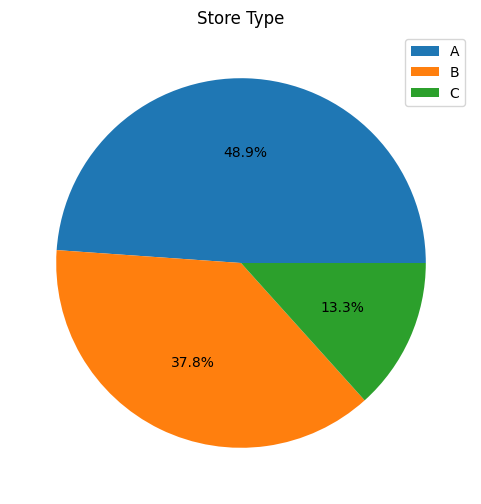

In [10]:
# draw pie chart of store type given by df_stores
df_stores = df_stores_raw.toPandas()
df_stores["Type"].value_counts().plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=None).set_title("Store Type")
plt.axis("off")
plt.legend(labels=df_stores["Type"].value_counts().index, loc="upper right")

In [11]:
df_train_pd = df_train.toPandas()

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Text(0.5, 1.0, 'Size, Type vs Weekly_Sales')

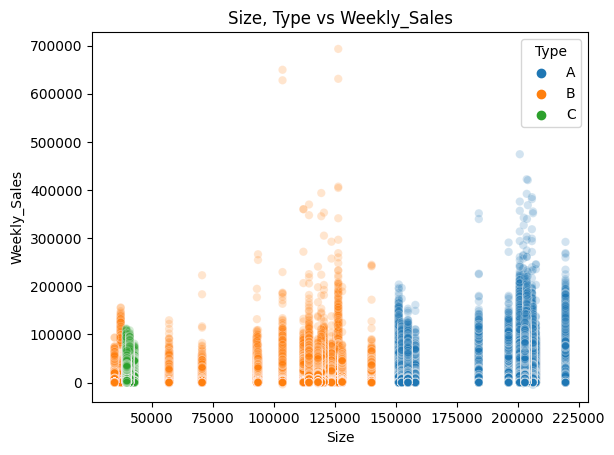

In [12]:
sns.scatterplot(x="Size", y="Weekly_Sales", data=df_train_pd, hue="Type", alpha=0.2).set_title("Size, Type vs Weekly_Sales")

Text(0.5, 1.0, 'IsHoliday vs Weekly_Sales')

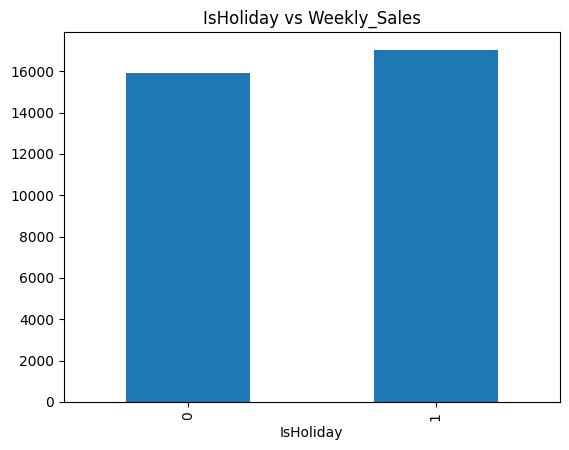

In [13]:
df_train_pd.groupby("IsHoliday")["Weekly_Sales"].mean().plot.bar().set_title("IsHoliday vs Weekly_Sales")

Text(0.5, 1.0, 'Fuel_Price vs Weekly_Sales')

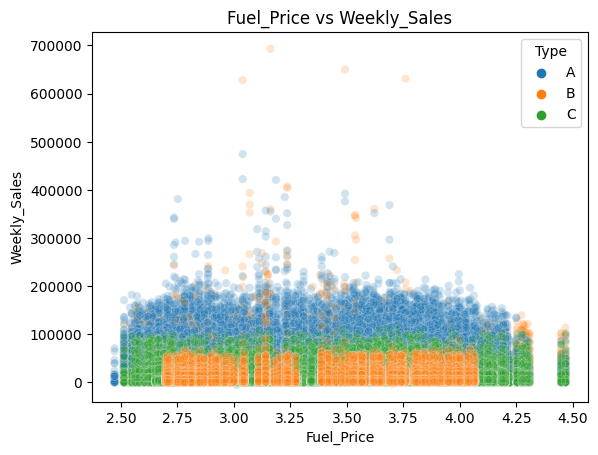

In [14]:
sns.scatterplot(x="Fuel_Price", y="Weekly_Sales", hue="Type", data=df_train_pd, alpha=0.2).set_title("Fuel_Price vs Weekly_Sales")

Text(0.5, 1.0, 'Unemployment vs Weekly_Sales')

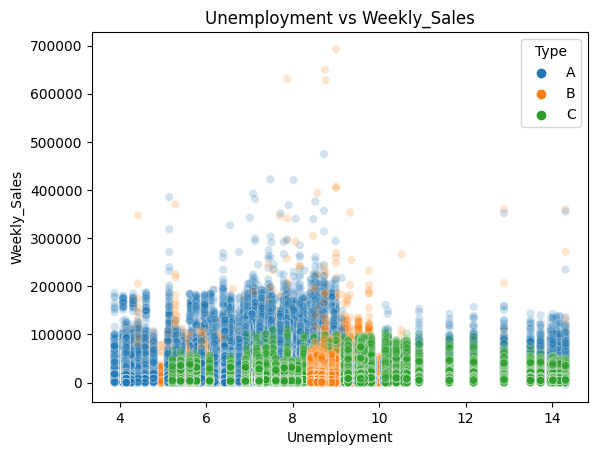

In [15]:
# find relationship between Unemployment and Weekly_Sales
sns.scatterplot(x="Unemployment", y="Weekly_Sales", hue="Type", data=df_train_pd, alpha=0.2).set_title("Unemployment vs Weekly_Sales")


Text(0.5, 1.0, 'CPI vs Weekly_Sales')

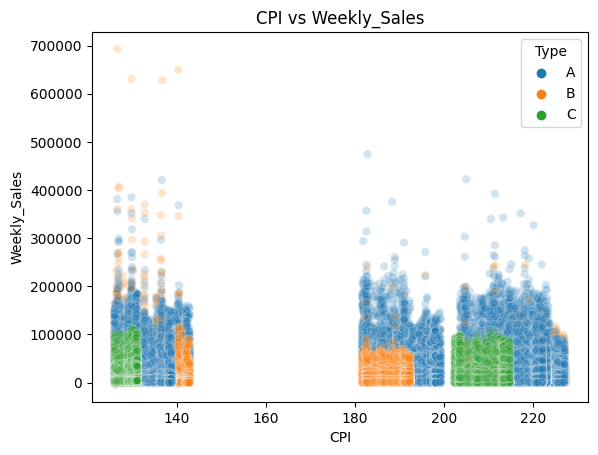

In [16]:
# find relationship between CPI and Weekly_Sales
sns.scatterplot(x="CPI", y="Weekly_Sales", hue="Type", data=df_train_pd, alpha=0.2).set_title("CPI vs Weekly_Sales")

Text(0.5, 1.0, 'Temperature vs Weekly_Sales')

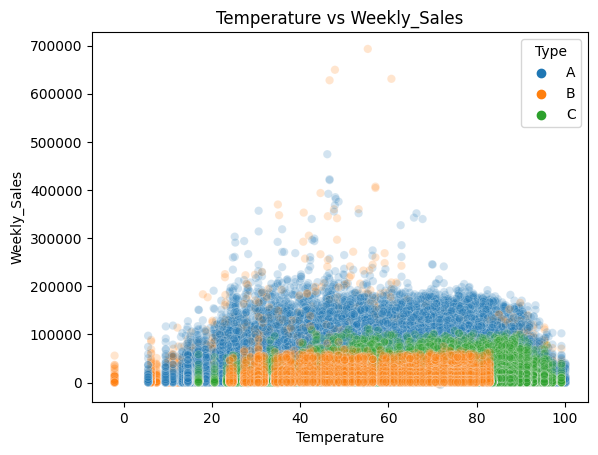

In [17]:
# find relationship between Temperature and Weekly_Sales
sns.scatterplot(x="Temperature", y="Weekly_Sales", hue="Type", data=df_train_pd, alpha=0.2).set_title("Temperature vs Weekly_Sales")

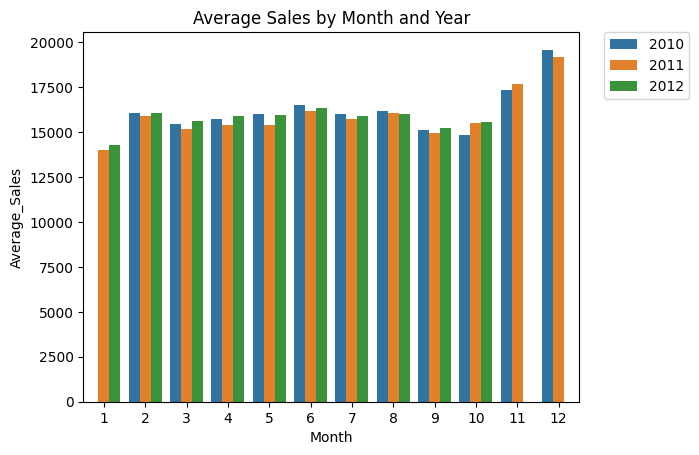

In [18]:
average_sales_by_time = spark.sql("SELECT Year, Month, AVG(Weekly_Sales) AS Average_Sales FROM df_train GROUP BY Year, Month ORDER BY Year, Month")
average_sales_by_time_pd = average_sales_by_time.toPandas()
sns.barplot(x="Month", y="Average_Sales", hue='Year', data=average_sales_by_time_pd).set_title("Average Sales by Month and Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [10]:
types = df_train.select("Type").distinct().collect()
types.sort()
mapping = {t.Type: str(i) for i, t in enumerate(types)}
df_train = df_train.replace(mapping, subset=["Type"])
df_test = df_test.replace(mapping, subset=["Type"])
df_train = df_train.withColumn("Type", df_train["Type"].cast(IntegerType()))
df_test = df_test.withColumn("Type", df_test["Type"].cast(IntegerType()))
df_train_pd = df_train.toPandas()
df_train.show(5)

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


+-----+-------------------+---------+----+------------+-----------+----------+---------+------------+----+------+----+-----+----+
|Store|               Date|IsHoliday|Dept|Weekly_Sales|Temperature|Fuel_Price|      CPI|Unemployment|Type|  Size|Year|Month|Week|
+-----+-------------------+---------+----+------------+-----------+----------+---------+------------+----+------+----+-----+----+
|    1|2010-02-05 00:00:00|        0|   1|     24924.5|      42.31|     2.572|211.09636|       8.106|   0|151315|2010|    2|   5|
|    1|2010-02-12 00:00:00|        1|   1|    46039.49|      38.51|     2.548|211.24217|       8.106|   0|151315|2010|    2|   6|
|    1|2010-02-19 00:00:00|        0|   1|    41595.55|      39.93|     2.514|211.28914|       8.106|   0|151315|2010|    2|   7|
|    1|2010-02-26 00:00:00|        0|   1|    19403.54|      46.63|     2.561|211.31964|       8.106|   0|151315|2010|    2|   8|
|    1|2010-03-05 00:00:00|        0|   1|     21827.9|       46.5|     2.625|211.35014|  

In [11]:
# find correlation between attributes and Weekly_Sales
results = df_train_pd.corr()["Weekly_Sales"].sort_values(ascending=False)
print(results)


/tmp/ipykernel_16/3010913235.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  results = df_train_pd.corr()["Weekly_Sales"].sort_values(ascending=False)


Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
Month           0.028409
Week            0.027673
IsHoliday       0.012774
Fuel_Price     -0.000120
Temperature    -0.002312
Year           -0.010111
CPI            -0.020921
Unemployment   -0.025864
Store          -0.085195
Type           -0.182242
Name: Weekly_Sales, dtype: float64


In [12]:
keep_cols = results[results.abs() > 0.01].index.values
print("Training attribute: ", keep_cols)
ignore_attributes = set(df_train_pd.columns) - set(keep_cols)
print("Ignore attribute: ", ignore_attributes)


Training attribute:  ['Weekly_Sales' 'Size' 'Dept' 'Month' 'Week' 'IsHoliday' 'Year' 'CPI'
 'Unemployment' 'Store' 'Type']
Ignore attribute:  {'Fuel_Price', 'Date', 'Temperature'}


In [13]:
df_train_clean = df_train.drop(*ignore_attributes)
df_test_clean = df_test.drop(*ignore_attributes)


In [14]:
df_train_clean_, df_val = df_train_clean.randomSplit([0.8, 0.2], seed=42)

In [44]:
# convert to pandas dataframe
df_train_clean_pd = df_train_clean.toPandas()

input_col = ["Store", "IsHoliday", "Size", "CPI", "Unemployment", "Year", "Month", "Week", "Type"]
output_col = "Weekly_Sales"

In [40]:
break_date1 = pd.Timestamp("2011-06-05")
break_week = break_date1.week
break_year = break_date1.year
# filter data before break_
df_train_clean_pd = df_train_clean_pd[(df_train_clean_pd["Year"] < break_year) | ((df_train_clean_pd["Year"] == break_year) & (df_train_clean_pd["Week"] <= break_week))]

In [45]:
print(len(df_train_clean_pd))

# df_train_clean_pd = df_train_clean_pd[['Store', 'IsHoliday', 'Type', 'Size', 'Week','Dept','Year']]
# df_train_clean_pd.info()

421570


In [48]:
# import RandomForestRegressor from sckit-learn
# from sklearn.ensemble import RandomForestRegressor
import sklearn.ensemble
from sklearn.utils import parallel_backend
from joblibspark import register_spark
from sklearn.model_selection import GridSearchCV

register_spark()

rnd = sklearn.ensemble.RandomForestRegressor()

grid_param = {
    'max_depth': [25, 30, 35],
    'max_features': [1.0, 0.9, 0.8],
    'max_samples': [0.5, 0.75, 1.0]
}

with parallel_backend('spark'):
    grid_search = GridSearchCV(estimator=rnd,
                               param_grid=grid_param,
                               cv=5,
                               n_jobs=-1,
                               verbose=2)
    grid_search.fit(df_train_clean_pd[['Store', 'IsHoliday', 'Type', 'Size', 'Week','Dept','Year']], df_train_clean_pd[output_col])


# rnd = sklearn.ensemble.RandomForestRegressor(random_state=42, max_samples=320000
#                             ,max_features=6,max_depth=25).fit(df_train_clean_pd[['Store', 'IsHoliday', 'Type', 'Size', 'Week','Dept','Year']], df_train_clean_pd[output_col])



In [49]:
# get mean absolute error
from sklearn.metrics import mean_absolute_error
train_pred = rnd.predict(df_train_clean_pd[['Store', 'IsHoliday', 'Type', 'Size', 'Week','Dept','Year']])
print("Train MAE: ", mean_absolute_error(df_train_clean_pd[output_col], train_pred))

Train MAE:  642.8822517251613


In [45]:
# create regression model
input_cols = df_train_clean.columns 
input_cols.remove("Weekly_Sales")
output_col = "Weekly_Sales"
print("Input columns: ", input_cols)
print("Output column: ", output_col)

Input columns:  ['Store', 'IsHoliday', 'Dept', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week']
Output column:  Weekly_Sales


In [46]:
# convert Store, IsHoliday, Type to One hot encoding
encoder = OneHotEncoder(inputCols=["Store", "IsHoliday", "Type"], outputCols=["Store_vec", "IsHoliday_vec", "Type_vec"])
encoder = encoder.fit(df_train_clean)
df_train_clean_ = encoder.transform(df_train_clean_)
df_val = encoder.transform(df_val)
df_test_clean = encoder.transform(df_test_clean)
df_train_clean_.show(5)

+-----+---------+----+------------+---------+------------+----+------+----+-----+----+--------------+-------------+-------------+
|Store|IsHoliday|Dept|Weekly_Sales|      CPI|Unemployment|Type|  Size|Year|Month|Week|     Store_vec|IsHoliday_vec|     Type_vec|
+-----+---------+----+------------+---------+------------+----+------+----+-----+----+--------------+-------------+-------------+
|    1|        0|   1|    14537.37|215.73323|       7.962|   0|151315|2011|    8|  34|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
|    1|        0|   1|    14539.79|215.60579|       7.962|   0|151315|2011|    8|  32|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
|    1|        0|   1|    14773.04| 210.6171|       7.808|   0|151315|2010|    5|  20|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
|    1|        0|   1|    14978.09|214.99806|       7.682|   0|151315|2011|    6|  24|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|
|    1|        0|   1|    15136.78|215.73392|       7.682|   0|151315|2011|    5|  20|(45,

In [48]:
explain_cols = ["Store_vec", "IsHoliday_vec", "Type_vec", "Size", "CPI", "Unemployment", "Year", "Month", "Week"]
label_col = ["Weekly_Sales"]

In [73]:
def get_wmse(df, predict_col="prediction", label_col="Weekly_Sales"):
    df = df.withColumn("weight", when(df["IsHoliday"] == 1, 5).otherwise(1))
    metric = RegressionEvaluator(predictionCol=predict_col, labelCol=label_col, metricName="mae", weightCol="weight")
    wmae = metric.evaluate(df, {metric.metricName: "mae"})
    return wmae

In [69]:
assembler = VectorAssembler(inputCols=explain_cols, outputCol="features")
# normalize features and label
# normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
# normalizer_label = Normalizer(inputCol="Weekly_Sales", outputCol="label_norm", p=1.0)
# create random forest regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Weekly_Sales", maxDepth=25, numTrees=100, seed=42)
# lr  = GBTRegressor(featuresCol="features", labelCol="Weekly_Sales", maxDepth=10, maxIter=10, seed=42)
# pipeline = pyspark.ml.Pipeline(stages=[assembler, normalizer, normalizer_label, rf])
pipeline = pyspark.ml.Pipeline(stages=[assembler, rf])
model = pipeline.fit(df_train_clean_)

# get 

23/01/28 15:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1108.4 KiB


23/01/28 15:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1870.3 KiB


23/01/28 15:17:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/01/28 15:18:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/28 15:18:31 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


23/01/28 15:18:58 WARN DAGScheduler: Broadcasting large task binary with size 1285.7 KiB


23/01/28 15:19:02 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


23/01/28 15:19:33 WARN DAGScheduler: Broadcasting large task binary with size 1637.6 KiB


23/01/28 15:19:38 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


23/01/28 15:20:10 WARN DAGScheduler: Broadcasting large task binary with size 1979.5 KiB


23/01/28 15:20:16 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


23/01/28 15:20:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/01/28 15:21:03 WARN DAGScheduler: Broadcasting large task binary with size 20.2 MiB


23/01/28 15:21:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/01/28 15:21:57 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB


23/01/28 15:22:35 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/01/28 15:22:41 WARN DAGScheduler: Broadcasting large task binary with size 28.0 MiB


23/01/28 15:23:11 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/01/28 15:23:20 WARN DAGScheduler: Broadcasting large task binary with size 31.6 MiB


23/01/28 15:24:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/01/28 15:24:35 WARN DAGScheduler: Broadcasting large task binary with size 34.7 MiB


23/01/28 15:25:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/01/28 15:25:56 WARN DAGScheduler: Broadcasting large task binary with size 37.3 MiB


23/01/28 15:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1893.2 KiB


23/01/28 15:27:18 WARN DAGScheduler: Broadcasting large task binary with size 39.6 MiB


23/01/28 15:28:26 WARN DAGScheduler: Broadcasting large task binary with size 1609.8 KiB


23/01/28 15:28:37 WARN DAGScheduler: Broadcasting large task binary with size 41.3 MiB


23/01/28 15:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1278.2 KiB


23/01/28 15:29:53 WARN DAGScheduler: Broadcasting large task binary with size 42.6 MiB


23/01/28 15:31:06 WARN DAGScheduler: Broadcasting large task binary with size 43.5 MiB


23/01/28 15:32:19 WARN DAGScheduler: Broadcasting large task binary with size 43.8 MiB


23/01/28 15:33:19 WARN DAGScheduler: Broadcasting large task binary with size 43.8 MiB


In [74]:

print("Training WMAE: ", get_wmse(model.transform(df_train_clean_)))

Training WMAE:  14403.80399533208


In [70]:
# evaluate model
df_val_pred = model.transform(df_val)


In [71]:
df_val_pred.show()


+-----+---------+----+------------+---------+------------+----+------+----+-----+----+--------------+-------------+-------------+--------------------+------------------+
|Store|IsHoliday|Dept|Weekly_Sales|      CPI|Unemployment|Type|  Size|Year|Month|Week|     Store_vec|IsHoliday_vec|     Type_vec|            features|        prediction|
+-----+---------+----+------------+---------+------------+----+------+----+-----+----+--------------+-------------+-------------+--------------------+------------------+
|    1|        0|   1|    14689.24|215.66931|       7.962|   0|151315|2011|    8|  33|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(54,[1,45,46,48,4...| 22055.75738542913|
|    1|        0|   1|    15277.27|215.79713|       7.962|   0|151315|2011|    9|  35|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(54,[1,45,46,48,4...|22008.380189089774|
|    1|        0|   1|    15360.45|211.23514|       7.787|   0|151315|2010|    7|  29|(45,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(54,[1,45,46,48,4...|